# Example of generating a SWAN simulation

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import rompy
import intake
import numpy as np
from rompy.swan import SwanModel, SwanGrid
import xarray as xr
xr.set_options(display_style='text')

### Instantiate a model simulation

In [3]:
new_simulation = SwanModel(run_id='test_swan',
                           template='../rompy/templates/swan',
#                            checkout='88c529557db', #allows for the optional specification of a particular commit for reproducability
                           output_dir='simulations')

Default context: (from cookiecutter.json)
OrderedDict([('run_id', 'run_0001'),
             ('compute_start', '20200221.040000'),
             ('compute_interval', '0.25 HR'),
             ('compute_stop', '20200224.040000'),
             ('out_start', '20200221.040000'),
             ('out_intvl', '1.0 HR'),
             ('output_locs',
              OrderedDict([('coords',
                            [['115.61', '-32.618'],
                             ['115.686067', '-32.532381']])])),
             ('cgrid', 'REG 115.68 -32.76 77 0.39 0.15 389 149'),
             ('cgrid_read', ''),
             ('wind_grid',
              'REG 115.3 -32.8 0.0 2 3 0.3515625 0.234375  NONSTATION '
              '20200221.040000  10800.0 S'),
             ('wind_read', "SERIES 'extracted.wind' 1 FORMAT '(3F8.1)'"),
             ('bottom_grid',
              'REG 115.68 -32.76 77 390 150 0.001 0.001 EXC -99.0'),
             ('bottom_file', 'bathy.bot'),
             ('friction', 'MAD'),
             (

In [4]:
# Setting start out empty, only need to add values from the default context we want to replace
new_simulation.settings

{'_template': '../rompy/templates/swan', '_checkout': None, 'model': 'SWAN'}

### Parse the parameters of the grid defined in the template and create a SwanGrid object to conveniently get the bounding box

In [5]:
grid=new_simulation.grid

(<Figure size 720x509.002 with 1 Axes>, <GeoAxesSubplot:>)

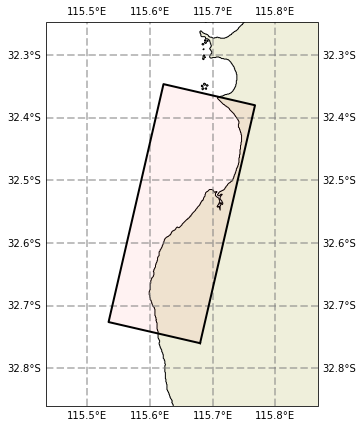

In [6]:
grid.plot()

In [7]:
min_lon, min_lat, max_lon, max_lat = grid.bbox(buffer=0.05)

## Set simulation timeframe

In [8]:
import pandas as pd

startdt = pd.to_datetime('2020-12-14 00:00')
enddt = startdt + pd.to_timedelta(1.,'d')

new_simulation.settings['compute_start'] = startdt.strftime('%Y%m%d.%H%M%S')
new_simulation.settings['compute_stop'] = enddt.strftime('%Y%m%d.%H%M%S')
new_simulation.settings['out_start'] = new_simulation.settings['compute_start']
new_simulation.settings

{'_template': '../rompy/templates/swan',
 '_checkout': None,
 'model': 'SWAN',
 'compute_start': '20201214.000000',
 'compute_stop': '20201215.000000',
 'out_start': '20201214.000000'}

## Gather boundary conditions

### Winds

Use the winds in the BoM Wavewatch model available on NCI

In [9]:
ds_wind = rompy.cat.bom.wavewatch3_nci(startdt=startdt,
                                       enddt=enddt,
                                       fmt_fields={'fcdate':[startdt.strftime('%Y%m%d')],
                                                   'hr':['0000'],
                                                   'grid':['PER'],
                                                   'output':['msh']},
                                       ds_filters={'subset':['longitude','latitude','uwnd','vwnd']},
                                       hindcast=True
                                      ).to_dask()

# Crop to the region of the model domain and load data to memory for later interpolation
ds_t0 = ds_wind.isel(time=0,drop=True)
inds = (ds_t0.longitude > min_lon) & (ds_t0.longitude < max_lon) & (ds_t0.latitude > min_lat) & (ds_t0.latitude < max_lat)
ds_wind = ds_wind.isel(node=inds).load()

ds_wind

<xarray.Dataset>
Dimensions:    (node: 1637, time: 25)
Coordinates:
  * time       (time) datetime64[ns] 2020-12-14 ... 2020-12-15
    init       (time) datetime64[ns] 2020-12-14 2020-12-14 ... 2020-12-14
    lead       (time) int64 0 1 2 3 4 5 6 7 8 9 ... 16 17 18 19 20 21 22 23 24
Dimensions without coordinates: node
Data variables:
    longitude  (node, time) float32 115.7 115.7 115.7 ... 115.5 115.5 115.5
    latitude   (node, time) float32 -32.3 -32.3 -32.3 ... -32.32 -32.32 -32.32
    uwnd       (node, time) float32 -1.8 -0.7 0.0 1.2 ... -7.3 -6.9 -6.5 -6.3
    vwnd       (node, time) float32 4.7 4.5 4.5 4.5 4.6 ... 4.2 3.5 2.9 2.2 1.6
Attributes:
    WAVEWATCH_III_version_number:    6.07
    WAVEWATCH_III_switches:          O0 O1 O2 IS0 IC0 REF0 PR3 UQ LN1 FLX4 ST...
    product_name:                    per.2020.nc
    history:                         Mon Dec 14 14:01:46 2020: ncks --overwri...
    NCO:                             netCDF Operators version 4.7.7 (Homepage...
    Conventions:                     CF-1.6, ACDD-1.3
    id:                              f1762_5247_9737_2398
    naming_authority:                au.org.nci
    title:                           AUSWAVE
    date_created:                    2020-12-14T14:02:39Z
    date_modified:                   2020-12-14T14:02:39Z
    date_issued:                     2020-12-14T14:02:39Z
    references:                      http://www.bom.gov.au/research/
    source:                          Perth triangular
    program:                         WAVEWATCH_III(R)_version_number_6.07
    comment:                         WAVEWATCH_III_switches: O0 O1 O2 IS0 IC0...
    summary:                         (C) 2020. Research version of marine for...
    standard_name_vocabulary:        CF Standard Name Table v47
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Waves
    institution:                     Australian Bureau of Meteorology
    project:                         ep4
    creator_name:                    Australian Bureau of Meteorology
    creator_url:                     http://www.bom.gov.au
    creator_email:                   oceanservices@bom.gov.au
    contributor_name:                Stefan Zieger
    contributor_role:                Research Scientist at Bureau of Meteorology
    publisher_url:                   http://www.bom.gov.au
    publisher_name:                  Australian Bureau of Meteorology
    publisher_email:                 oceanservices@bom.gov.au
    acknowledgement:                 Any users of this data are required to c...
    license:                         Data is not to be copied or reproduced w...
    disclaimer:                      You accept all risks and responsibility ...
    distribution_statement:          see license
    notes:                           [1] This dataset is a preliminary foreca...
    geospatial_lat_max:              -31.3
    geospatial_lat_min:              -34.0
    geospatial_lat_units:            degrees_north
    geospatial_lat_resolution:       n/a
    geospatial_lon_max:              115.77367
    geospatial_lon_min:              114.4
    geospatial_lon_units:            degrees_east
    geospatial_lon_resolution:       n/a
    geospatial_bounds:               POLYGON((114.400002 -34.000000,114.40000...
    time_coverage_start:             2020-12-14T00:00:00Z
    time_coverage_end:               2020-12-21T00:00:00Z
    time_coverage_resolution:        PT1H28S
    time_coverage_duration:          P7D
    processing_level:                0 (raw model output)
    DODS_EXTRA.Unlimited_Dimension:  time

Setup a regular swan grid to interpolate the unstructured wind mesh onto

In [10]:
from tqdm import trange
from scipy.interpolate import LinearNDInterpolator
import xarray as xr

dx = 0.002
wind_grid = SwanGrid(gridtype='REG',
                     x0=min_lon,
                     y0=min_lat,
                     dx=dx,
                     dy=dx,
                     nx=int((max_lon-min_lon)/dx),
                     ny=int((max_lat-min_lat)/dx),
                     rot=0
                    )

interp_vars = {'uwnd':[],'vwnd':[]}
for var,values in interp_vars.items():
    for t in trange(len(ds_wind.time),desc=var):
        ds_t = ds_wind.isel(time=t)
        interp = LinearNDInterpolator(list(zip(ds_t.longitude, ds_t.latitude)), ds_t[var], fill_value=0)
        values.append(interp(wind_grid.x,wind_grid.y))

ds_wind_interpolated = xr.Dataset({'time':ds_wind.time,
                                   'lon':(('m','n'),wind_grid.x),
                                   'lat':(('m','n'),wind_grid.y),
                                   'u10':(('time','m','n'),np.array(interp_vars['uwnd'])),
                                   'v10':(('time','m','n'),np.array(interp_vars['vwnd'])),
                                  })
ds_wind_interpolated

vwnd: 100%|██████████| 25/25 [00:06<00:00,  3.64it/s]


<xarray.Dataset>
Dimensions:  (m: 257, n: 167, time: 25)
Coordinates:
    init     (time) datetime64[ns] 2020-12-14 2020-12-14 ... 2020-12-14
    lead     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 15 16 17 18 19 20 21 22 23 24
  * time     (time) datetime64[ns] 2020-12-14 2020-12-14T01:00:00 ... 2020-12-15
Dimensions without coordinates: m, n
Data variables:
    lon      (m, n) float64 115.5 115.5 115.5 115.5 ... 115.8 115.8 115.8 115.8
    lat      (m, n) float64 -32.81 -32.81 -32.81 -32.81 ... -32.3 -32.3 -32.3
    u10      (time, m, n) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    v10      (time, m, n) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

Write the interpolated winds to swan format, this function returns the corresponding swan commands for including in the simulation INPUT file

In [11]:
inpwind, readwind = ds_wind_interpolated.swan.to_inpgrid(new_simulation.staging_dir + '/wind.inp',
                                                          var='WIND',
                                                          grid=wind_grid,
                                                          z1='u10',z2='v10')
print(inpwind)
print(readwind)
new_simulation.settings['wind_grid'] = inpwind
new_simulation.settings['wind_read'] = readwind

REG 115.48384449028222 -32.809999999999995 0 166 256 0.002 0.002 NONSTATION 20201214.000000 1.0 HR
1 'wind.inp' 3 0 1 0 FREE


### Wave Spectra

In [12]:
ds_spec = rompy.cat.bom.wavewatch3_nci(startdt=startdt,
                                       enddt=enddt,
                                       fmt_fields={'fcdate':[startdt.strftime('%Y%m%d')],
                                                   'hr':['0000'],
                                                   'grid':['PER'],
                                                   'output':['spec']},
                                       ds_filters={'rename':{'dir':'mean_dir'},
                                                   'sort':['direction']},
                                       hindcast=True
                                      ).to_dask()
ds_spec

<xarray.Dataset>
Dimensions:       (direction: 24, frequency: 29, station: 167, time: 25)
Coordinates:
  * direction     (direction) float32 7.5 22.5 37.5 52.5 ... 322.5 337.5 352.5
  * frequency     (frequency) float32 0.035 0.0385 0.04235 ... 0.4589 0.5047
  * station       (station) int32 1 2 3 4 5 6 7 ... 161 162 163 164 165 166 167
  * time          (time) datetime64[ns] 2020-12-14 ... 2020-12-15
    init          (time) datetime64[ns] 2020-12-14 2020-12-14 ... 2020-12-14
    lead          (time) int64 0 1 2 3 4 5 6 7 8 ... 16 17 18 19 20 21 22 23 24
Data variables:
    frequency1    (frequency, time) float32 dask.array<chunksize=(29, 25), meta=np.ndarray>
    frequency2    (frequency, time) float32 dask.array<chunksize=(29, 25), meta=np.ndarray>
    station_name  (station, time) |S64 dask.array<chunksize=(167, 25), meta=np.ndarray>
    crs           (time) int32 -2147483647 -2147483647 ... -2147483647
    cur           (station, time) float32 dask.array<chunksize=(167, 25), meta=np.ndarray>
    curdir        (station, time) float32 dask.array<chunksize=(167, 25), meta=np.ndarray>
    mean_dir      (station, time) float32 dask.array<chunksize=(167, 25), meta=np.ndarray>
    dp            (station, time) float32 dask.array<chunksize=(167, 25), meta=np.ndarray>
    dp_sea        (station, time) float32 dask.array<chunksize=(167, 25), meta=np.ndarray>
    dp_sw         (station, time) float32 dask.array<chunksize=(167, 25), meta=np.ndarray>
    dpt           (station, time) float32 dask.array<chunksize=(167, 25), meta=np.ndarray>
    efth          (station, frequency, direction, time) float32 dask.array<chunksize=(167, 29, 24, 25), meta=np.ndarray>
    hs            (station, time) float32 dask.array<chunksize=(167, 25), meta=np.ndarray>
    hs_sea        (station, time) float32 dask.array<chunksize=(167, 25), meta=np.ndarray>
    hs_sw         (station, time) float32 dask.array<chunksize=(167, 25), meta=np.ndarray>
    latitude      (station, time) float32 dask.array<chunksize=(167, 25), meta=np.ndarray>
    longitude     (station, time) float32 dask.array<chunksize=(167, 25), meta=np.ndarray>
    pdir0         (station, time) float32 dask.array<chunksize=(167, 25), meta=np.ndarray>
    pdir1         (station, time) float32 dask.array<chunksize=(167, 25), meta=np.ndarray>
    pdir2         (station, time) float32 dask.array<chunksize=(167, 25), meta=np.ndarray>
    pdp0          (station, time) float32 dask.array<chunksize=(167, 25), meta=np.ndarray>
    pdp1          (station, time) float32 dask.array<chunksize=(167, 25), meta=np.ndarray>
    pdp2          (station, time) float32 dask.array<chunksize=(167, 25), meta=np.ndarray>
    phs0          (station, time) float32 dask.array<chunksize=(167, 25), meta=np.ndarray>
    phs1          (station, time) float32 dask.array<chunksize=(167, 25), meta=np.ndarray>
    phs2          (station, time) float32 dask.array<chunksize=(167, 25), meta=np.ndarray>
    ppe0          (station, time) float32 dask.array<chunksize=(167, 25), meta=np.ndarray>
    ppe1          (station, time) float32 dask.array<chunksize=(167, 25), meta=np.ndarray>
    ppe2          (station, time) float32 dask.array<chunksize=(167, 25), meta=np.ndarray>
    psig1         (station, time) float32 dask.array<chunksize=(167, 25), meta=np.ndarray>
    psig2         (station, time) float32 dask.array<chunksize=(167, 25), meta=np.ndarray>
    ptp0          (station, time) float32 dask.array<chunksize=(167, 25), meta=np.ndarray>
    ptp1          (station, time) float32 dask.array<chunksize=(167, 25), meta=np.ndarray>
    ptp2          (station, time) float32 dask.array<chunksize=(167, 25), meta=np.ndarray>
    swe           (station, time) float32 dask.array<chunksize=(167, 25), meta=np.ndarray>
    t01           (station, time) float32 dask.array<chunksize=(167, 25), meta=np.ndarray>
    t02           (station, time) float32 dask.array<chunksize=(167, 25), meta=np.ndarray>
    tp            (station, time) float32 dask

In [13]:
import wavespectra as ws
ds_spec = ws.read_dataset(ds_spec) #Convert it to wavespectra format
ds_spec = ds_spec.sortby('dir')
ds_spec

<xarray.Dataset>
Dimensions:  (dir: 24, freq: 29, site: 167, time: 25)
Coordinates:
  * dir      (dir) float32 7.5 22.5 37.5 52.5 67.5 ... 307.5 322.5 337.5 352.5
  * freq     (freq) float32 0.035 0.0385 0.04235 ... 0.4171 0.4589 0.5047
  * site     (site) int32 1 2 3 4 5 6 7 8 9 ... 160 161 162 163 164 165 166 167
  * time     (time) datetime64[ns] 2020-12-14 2020-12-14T01:00:00 ... 2020-12-15
    init     (time) datetime64[ns] 2020-12-14 2020-12-14 ... 2020-12-14
    lead     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 15 16 17 18 19 20 21 22 23 24
Data variables:
    dpt      (site, time) float32 dask.array<chunksize=(167, 25), meta=np.ndarray>
    efth     (site, freq, dir, time) float32 dask.array<chunksize=(167, 29, 24, 25), meta=np.ndarray>
    lat      (site) float32 dask.array<chunksize=(167,), meta=np.ndarray>
    lon      (site) float32 dask.array<chunksize=(167,), meta=np.ndarray>
    wspd     (site, time) float32 dask.array<chunksize=(167, 25), meta=np.ndarray>
    wdir     (site, time) float32 dask.array<chunksize=(167, 25), meta=np.ndarray>
Attributes:
    product_name:                    per.2020_src.nc
    history:                         Mon Dec 14 14:01:41 2020: ncks --overwri...
    NCO:                             netCDF Operators version 4.7.7 (Homepage...
    date_created:                    2020-12-14T14:02:20Z
    program:                         WAVEWATCH_III(R)_version_number_6.07
    Conventions:                     CF-1.6, ACDD-1.3
    id:                              f1762_5247_9737_2398
    naming_authority:                au.org.nci
    title:                           AUSWAVE
    date_modified:                   2020-12-14T14:02:20Z
    date_issued:                     2020-12-14T14:02:20Z
    references:                      http://www.bom.gov.au/research/
    source:                          Perth triangular
    comment:                         WAVEWATCH_III_switches: O0 O1 O2 IS0 IC0...
    summary:                         (C) 2020. Research version of marine for...
    standard_name_vocabulary:        CF Standard Name Table v47
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Waves
    institution:                     Australian Bureau of Meteorology
    project:                         ep4
    creator_name:                    Australian Bureau of Meteorology
    creator_url:                     http://www.bom.gov.au
    creator_email:                   oceanservices@bom.gov.au
    contributor_name:                Stefan Zieger
    contributor_role:                Research Scientist at Bureau of Meteorology
    publisher_url:                   http://www.bom.gov.au
    publisher_name:                  Australian Bureau of Meteorology
    publisher_email:                 oceanservices@bom.gov.au
    acknowledgement:                 Any users of this data are required to c...
    license:                         Data is not to be copied or reproduced w...
    disclaimer:                      You accept all risks and responsibility ...
    distribution_statement:          see license
    notes:                           [1] This dataset is a preliminary foreca...
    geospatial_lat_max:              -31.4953
    geospatial_lat_min:              -33.9909
    geospatial_lat_units:            degrees_north
    geospatial_lat_resolution:       n/a
    geospatial_lon_max:              115.7349
    geospatial_lon_min:              114.7644
    geospatial_lon_units:            degrees_east
    geospatial_lon_resolution:       n/a
    geospatial_bounds:               POLYGON((114.764397 -33.990898,114.76439...
    time_coverage_start:             2020-12-14T00:00:00Z
    time_coverage_end:               2020-12-21T00:00:00Z
    time_coverage_resolution:        PT1H28S
    time_coverage_duration:          P7D
    processing_level:                0 (raw model output)
    DODS.strlen:                     16
    D

### Find the spectra within some distance of the boundary

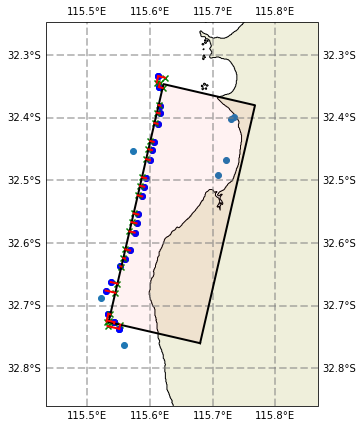

In [14]:
ds_boundary = grid.nearby_spectra(ds_spec,dist_thres=0.02)

### Times in swan controlled by spectra, make sure that they are consistent with the wind

In [15]:
check=[st == wt for st,wt in zip(ds_spec.time.values,ds_wind.time.values)]
any(check)

True

### Save spectral forcing to swan format

In [16]:
ds_boundary.spec.to_swan(new_simulation.staging_dir + '/' + new_simulation.default_context['spectra_file'])

### Setup spectral output points - a grid and specific points at buoys

In [17]:
output_locs = []

bbox = grid.bbox()

from owslib.wfs import WebFeatureService
wfs_url='http://geoserver-123.aodn.org.au/geoserver/wfs'
wfs_endpoint = 'aodn:aodn_wave_nrt_timeseries_map'
wfs = WebFeatureService(wfs_url,version='2.0.0')
response = wfs.getfeature(typename=wfs_endpoint,bbox=tuple(bbox),outputFormat='csv')
df = pd.read_csv(response)
df = df.groupby(['wmo_id','latitude','longitude']).mean()

for (wmo_id,yp,xp), data in df.iterrows():
    output_locs.append([str(round(xp,2)),str(round(yp,2))])

spec_int = 0.05
xx = np.arange(round(bbox[0]+spec_int,2),round(bbox[2]-spec_int,2),spec_int)
yy = np.arange(round(bbox[1]+spec_int,2),round(bbox[3]-spec_int,2),spec_int)
specout_x, specout_y = np.meshgrid(xx,yy)
for i, (xp,yp) in enumerate(zip(specout_x.ravel(),specout_y.ravel())):
    output_locs.append([str(round(xp,2)),str(round(yp,2))])

new_simulation.settings["output_locs"] = {'coords':output_locs}

### Generate the simulation files

In [18]:
new_simulation.settings

{'_template': '../rompy/templates/swan',
 '_checkout': None,
 'model': 'SWAN',
 'compute_start': '20201214.000000',
 'compute_stop': '20201215.000000',
 'out_start': '20201214.000000',
 'wind_grid': 'REG 115.48384449028222 -32.809999999999995 0 166 256 0.002 0.002 NONSTATION 20201214.000000 1.0 HR',
 'wind_read': "1 'wind.inp' 3 0 1 0 FREE",
 'output_locs': {'coords': [['115.57', '-32.45'],
   ['115.58', '-32.71'],
   ['115.63', '-32.71'],
   ['115.68', '-32.71'],
   ['115.58', '-32.66'],
   ['115.63', '-32.66'],
   ['115.68', '-32.66'],
   ['115.58', '-32.61'],
   ['115.63', '-32.61'],
   ['115.68', '-32.61'],
   ['115.58', '-32.56'],
   ['115.63', '-32.56'],
   ['115.68', '-32.56'],
   ['115.58', '-32.51'],
   ['115.63', '-32.51'],
   ['115.68', '-32.51'],
   ['115.58', '-32.46'],
   ['115.63', '-32.46'],
   ['115.68', '-32.46'],
   ['115.58', '-32.41'],
   ['115.63', '-32.41'],
   ['115.68', '-32.41']]}}

In [19]:
new_simulation.generate()

'/home/bra467/repos/rompy/notebooks/simulations/test_swan'

### retain the extracted data in netcdf format

In [20]:
ds_spec.to_netcdf(new_simulation.staging_dir + '/downloads/wavewatch.nc')
ds_wind.to_netcdf(new_simulation.staging_dir + '/downloads/access.nc')

### (optionally) zip up the files

In [21]:
# new_simulation.zip()

In [22]:
new_simulation.staging_dir 

'/home/bra467/repos/rompy/notebooks/simulations/test_swan'

### If a compiled version of the swan model is available this should run...

In [23]:
!cd simulations/test_swan && ~/swan4131/swan.exe


 SWAN is preparing computation

+SWAN is processing output request    1
+SWAN is processing output request    2
+SWAN is processing output request    3
 Number of threads during execution of parallel region = 12

+time 20201214.001500   , step      1; iteration    1; sweep 1
+time 20201214.001500   , step      1; iteration    1; sweep 2
+time 20201214.001500   , step      1; iteration    1; sweep 3
+time 20201214.001500   , step      1; iteration    1; sweep 4
+time 20201214.001500   , step      1; iteration    2; sweep 1
+time 20201214.001500   , step      1; iteration    2; sweep 2
+time 20201214.001500   , step      1; iteration    2; sweep 3
+time 20201214.001500   , step      1; iteration    2; sweep 4
+time 20201214.003000   , step      2; iteration    1; sweep 1
+time 20201214.003000   , step      2; iteration    1; sweep 2
+time 20201214.003000   , step      2; iteration    1; sweep 3
+time 20201214.003000   , step      2; iteration    1; sweep 4
+time 20201214.004500   , step